<a href="https://colab.research.google.com/github/JuanD4vy/DDoS_Detection_SDN/blob/main/DDoS_SDN__Detection_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Universidad Militar Nueva Granada***
**Juan David Aviles Palma**

**Telecommunications Engineering Program - Maxwell GISSIC research group**

#***0. Import libraries and load datasets***

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Libraries
import gc
import time
import numpy as np
import random
import pandas as pd
import ipaddress
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
# Seed for reproducibility
np.random.seed(0)
random.seed(0)

In [ ]:
# Load CIC-Dataset
cic_attack_train = pd.read_csv('/content/drive/MyDrive/ML_DDoS_SDN/Attack_CIC_train.csv')
cic_attack_test = pd.read_csv('/content/drive/MyDrive/ML_DDoS_SDN/Attack_CIC_test2.csv')
cic_normal_train = pd.read_csv('/content/drive/MyDrive/ML_DDoS_SDN/Normal_CIC_train.csv')
cic_normal_test = pd.read_csv('/content/drive/MyDrive/ML_DDoS_SDN/Normal_CIC_test2.csv')

In [ ]:
# Load NTL-Dataset
ntl_attack_train = pd.read_csv('/content/drive/MyDrive/ML_DDoS_SDN/Attack_NTL_train.csv')
ntl_attack_test = pd.read_csv('/content/drive/MyDrive/ML_DDoS_SDN/Attack_NTL_test2.csv')
ntl_normal_train = pd.read_csv('/content/drive/MyDrive/ML_DDoS_SDN/Normal_NTL_train.csv')
ntl_normal_test = pd.read_csv('/content/drive/MyDrive/ML_DDoS_SDN/Normal_NTL_test2.csv')

/tmp/ipython-input-3989820226.py:2: DtypeWarning: Columns (237,238) have mixed types. Specify dtype option on import or set low_memory=False.
  ntl_attack_train = pd.read_csv('/content/drive/MyDrive/ML_DDoS_SDN/Attack_NTL_train.csv')
/tmp/ipython-input-3989820226.py:3: DtypeWarning: Columns (237,238) have mixed types. Specify dtype option on import or set low_memory=False.
  ntl_attack_test = pd.read_csv('/content/drive/MyDrive/ML_DDoS_SDN/Attack_NTL_test2.csv')


#***1. Data exploration and preprocessing***

In [ ]:
# Normal Flow CIC-Dataset Size
print("Dimensions of the Normal Flow CIC-Dataset (Train):", cic_normal_train.shape)
print("Dimensions of the Normal Flow CIC-Dataset (Test):", cic_normal_test.shape)
print("============================================================================")
# Attack Flow CIC-Dataset Size
print("Dimensions of the Attack Flow CIC-Dataset (Train):", cic_attack_train.shape)
print("Dimensions of the Attack Flow CIC-Dataset (Test):", cic_attack_test.shape)

Dimensions of the Normal Flow CIC-Dataset (Train): (171420, 82)
Dimensions of the Normal Flow CIC-Dataset (Test): (50839, 82)
Dimensions of the Attack Flow CIC-Dataset (Train): (253502, 82)
Dimensions of the Attack Flow CIC-Dataset (Test): (75876, 82)


In [ ]:
# Tamaño de NTL-Dataset de flujo normal
print("Dimensions of the Normal Flow NTL-Dataset (Train):", ntl_normal_train.shape)
print("Dimensions of the Normal Flow NTL-Dataset (Test):", ntl_normal_test.shape)
print("===========================================================================")
# Tamaño de NTL-Dataset de flujo de ataque
print("Dimensions of the Attack Flow NTL-Dataset (Train):", ntl_attack_train.shape)
print("Dimensions of the Attack Flow NTL-Dataset (Test):", ntl_attack_test.shape)

Dimensions of the Normal Flow NTL-Dataset (Train): (362861, 347)
Dimensions of the Normal Flow NTL-Dataset (Test): (106086, 347)
Dimensions of the Attack Flow NTL-Dataset (Train): (368728, 347)
Dimensions of the Attack Flow NTL-Dataset (Test): (97589, 347)


In [ ]:
# Free memory immediately
gc.collect()

0

#*1.1* *CIC-Dataset Exploration and Processing*

In [ ]:
# The output column (Label) is added for each dataset
cic_attack_train['Label'] = 1
cic_attack_test['Label'] = 1
cic_normal_train['Label'] = 0
cic_normal_test['Label'] = 0

In [ ]:
# Combine the CIC-Training Datasets
cic_train_dataset = pd.concat([cic_attack_train, cic_normal_train], ignore_index=True)
cic_train_dataset = shuffle(cic_train_dataset, random_state=42)
# Combine the CIC-Dataset test
cic_test_dataset = pd.concat([cic_attack_test, cic_normal_test], ignore_index=True)
cic_test_dataset = shuffle(cic_test_dataset, random_state=42)

In [ ]:
# Display the new shape of the CIC-Dataset
print("Dimensions of the train CIC-Dataset:", cic_train_dataset.shape)
print("Dimensions of the test CIC-Dataset:", cic_test_dataset.shape)

Dimensions of the train CIC-Dataset: (424922, 83)
Dimensions of the test CIC-Dataset: (126715, 83)


In [ ]:
# Free memory (drop unused)
del cic_attack_train, cic_attack_test, cic_normal_train, cic_normal_test
gc.collect()

0

In [ ]:
# ================== SEGMENTO 1: Eliminar src_ip y dst_ip del CIC ==================
cic_train_dataset.drop(columns=['src_ip', 'dst_ip'], errors='ignore', inplace=True)
cic_test_dataset.drop(columns=['src_ip', 'dst_ip'], errors='ignore', inplace=True)

In [ ]:
# Ensure all data is numeric
cic_train_dataset = cic_train_dataset.select_dtypes(include=['number'])
cic_test_dataset = cic_test_dataset.select_dtypes(include=['number'])

#*1.2* *NTL-Dataset Exploration and Processing*

In [ ]:
# Identify columns with null values ​​and replace them with the mean
def replace_missing_values(dataset, name):
    dataset.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values ​​with NaN

    # Convert columns to numeric if possible
    for col in dataset.columns:
        dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

    missing_values = dataset.isnull().sum()
    missing_values = missing_values[missing_values > 0]

    print(f"Columns with null values ​​in {name}:", missing_values)

    # Fill with the average of each column
    dataset.fillna(dataset.mean(numeric_only=True), inplace=True)

    print(f"Null values ​​in {name} after replacement: {dataset.isnull().sum().sum()}")

for dataset, name in zip([ntl_attack_train, ntl_attack_test, ntl_normal_train, ntl_normal_test],
                        ['train_attack', 'test_attack', 'train_normal', 'test_normal']):
    replace_missing_values(dataset, name)

Columns with null values ​​in train_attack: flow_id                                 368728
timestamp                               368728
src_ip                                  368728
dst_ip                                  368728
protocol                                368728
payload_bytes_skewness                   29239
payload_bytes_cov                        29239
fwd_payload_bytes_skewness               19959
fwd_payload_bytes_cov                    19304
bwd_payload_bytes_skewness               33202
bwd_payload_bytes_cov                    33190
skewness_header_bytes                    34914
fwd_skewness_header_bytes                31150
bwd_skewness_header_bytes                21731
fwd_segment_size_skewness                19076
bwd_segment_size_skewness                18534
segment_size_skewness                    26897
active_skewness                             22
idle_skewness                               22
packets_IAT_skewness                     26097
packets_IAT_cov 

In [ ]:
# Combining and mixing data
ntl_train_dataset = pd.concat([ntl_attack_train, ntl_normal_train], ignore_index=True)
ntl_train_dataset = shuffle(ntl_train_dataset, random_state=42)
ntl_test_dataset = pd.concat([ntl_attack_test, ntl_normal_test], ignore_index=True)
ntl_test_dataset = shuffle(ntl_test_dataset, random_state=42)

In [ ]:
# ================== SEGMENTO 2: Eliminar src_ip y dst_ip del NTL ==================
ntl_train_dataset.drop(columns=['src_ip', 'dst_ip'], errors='ignore', inplace=True)
ntl_test_dataset.drop(columns=['src_ip', 'dst_ip'], errors='ignore', inplace=True)

In [ ]:
del ntl_attack_train, ntl_attack_test, ntl_normal_train, ntl_normal_test
gc.collect()

0

In [ ]:
# Check for null values ​​and remove columns with null data
cols_before = set(ntl_train_dataset.columns)
ntl_train_dataset.dropna(axis=1, inplace=True)
ntl_test_dataset.dropna(axis=1, inplace=True)
cols_after = set(ntl_train_dataset.columns)
eliminated_cols = cols_before - cols_after
print("Columns deleted for containing null values:", eliminated_cols)

Columns deleted for containing null values: {'protocol', 'timestamp', 'flow_id'}


In [ ]:
# Ensure that there is only numerical data
ntl_train_dataset = ntl_train_dataset.select_dtypes(include=np.number)
ntl_test_dataset = ntl_test_dataset.select_dtypes(include=np.number)

In [ ]:
# Replace infinite values and fill NaNs
ntl_train_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
ntl_test_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
ntl_train_dataset.fillna(0, inplace=True)
ntl_test_dataset.fillna(0, inplace=True)

#***2. Data analysis***

#*2.1* *CIC-Dataset Analysis*

In [ ]:
# CIC-Training and Testing Dataset Sizes
print("Train CIC-Dataset size:", cic_train_dataset.shape)
print("Test CIC-Dataset size:", cic_test_dataset.shape)

Train CIC-Dataset size: (424922, 80)
Test CIC-Dataset size: (126715, 80)


In [ ]:
# Check for null values
print("Null values ​​per column:\n", cic_train_dataset.isnull().sum())

Null values ​​per column:
 src_port            0
dst_port            0
protocol            0
flow_duration       0
flow_byts_s         0
                   ..
subflow_fwd_pkts    0
subflow_bwd_pkts    0
subflow_fwd_byts    0
subflow_bwd_byts    0
Label               0
Length: 80, dtype: int64


In [ ]:
print(cic_train_dataset['Label'].value_counts(normalize=True)) # Percentages of the output variable

Label
1    0.596585
0    0.403415
Name: proportion, dtype: float64


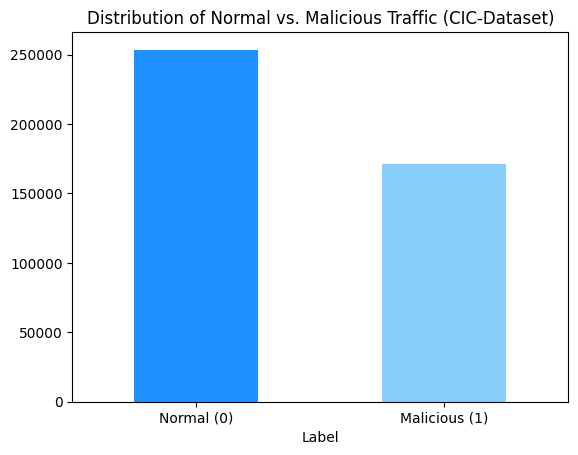

In [ ]:
cic_train_dataset['Label'].value_counts().plot(kind='bar', color=['dodgerblue', 'lightskyblue'])
plt.title('Distribution of Normal vs. Malicious Traffic (CIC-Dataset)')
plt.xticks([0, 1], ['Normal (0)', 'Malicious (1)'], rotation=0)
plt.show()

#*2.2* *NTL-Dataset Analysis*

In [ ]:
# Display the new shape of the NTL-Dataset
print("Dimensions of the train NTL-Dataset:", ntl_train_dataset.shape)
print("Dimensions of the test NTL-Dataset:", ntl_test_dataset.shape)

Dimensions of the train NTL-Dataset: (731589, 342)
Dimensions of the test NTL-Dataset: (203675, 342)


In [ ]:
# Check for null values
print("Null values ​​per column:\n", ntl_train_dataset.isnull().sum())

Null values ​​per column:
 src_port                                0
dst_port                                0
duration                                0
packets_count                           0
fwd_packets_count                       0
                                       ..
std_fwd_payload_bytes_delta_len         0
median_fwd_payload_bytes_delta_len      0
skewness_fwd_payload_bytes_delta_len    0
cov_fwd_payload_bytes_delta_len         0
label                                   0
Length: 342, dtype: int64


In [ ]:
print(ntl_train_dataset['label'].value_counts(normalize=True)) # Percentages of the output variable

label
1    0.50401
0    0.49599
Name: proportion, dtype: float64


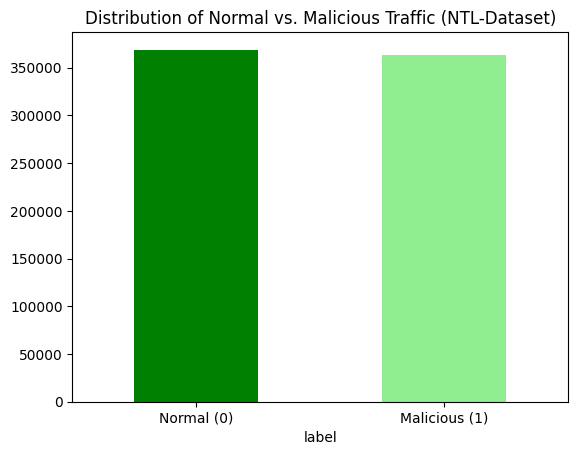

In [ ]:
ntl_train_dataset['label'].value_counts().plot(kind='bar', color=['green', 'lightgreen'])
plt.title('Distribution of Normal vs. Malicious Traffic (NTL-Dataset)')
plt.xticks([0, 1], ['Normal (0)', 'Malicious (1)'], rotation=0)
plt.show()

#***3. Feature Selection***

#*3.1* *Feature selection in CIC-Dataset*

In [ ]:
# Feature normalization
scaler = StandardScaler()
cic_X_train = cic_train_dataset.drop('Label', axis=1)
cic_y_train = cic_train_dataset['Label']
cic_X_test = cic_test_dataset.drop('Label', axis=1)
cic_y_test = cic_test_dataset['Label']

In [ ]:
# Align columns between train and test sets for CIC dataset
train_cols = cic_X_train.columns
test_cols = cic_X_test.columns
common_cols_cic = list(set(train_cols) & set(test_cols))
cic_X_train = cic_X_train[common_cols_cic]
cic_X_test = cic_X_test[common_cols_cic]


cic_X_train = scaler.fit_transform(cic_X_train)
cic_X_test = scaler.transform(cic_X_test)

In [ ]:
# Feature analysis with ExtraTreesClassifier for low RAM consumption
cic_et_classifier = ExtraTreesClassifier(
    n_estimators=50,       # Fewer trees to reduce memory and time
    random_state=42,
    n_jobs=-1              # Use all available cores
)

cic_et_classifier.fit(cic_X_train, cic_y_train)

ExtraTreesClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [ ]:
# Obtaining the importance of features
cic_feature_importance = cic_et_classifier.feature_importances_

# Create a DataFrame to show feature importance
cic_feature_importance_df = pd.DataFrame({'Feature': common_cols_cic, 'Importance': cic_feature_importance})
cic_feature_importance_df = cic_feature_importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
# View all features with their importance scores
cic_feature_list = cic_feature_importance_df[['Feature', 'Importance']].values.tolist()
print('Features and importance scores (CIC-Dataset):')
for feature, importance in cic_feature_list:
    print(f'{feature}: {importance:.4f}')

Features and importance scores (CIC-Dataset):
fwd_pkt_len_max: 0.0724
fwd_pkt_len_std: 0.0723
down_up_ratio: 0.0410
fwd_pkt_len_mean: 0.0368
flow_iat_max: 0.0331
flow_duration: 0.0304
pkt_len_max: 0.0304
bwd_pkt_len_max: 0.0294
fwd_seg_size_avg: 0.0273
pkt_len_mean: 0.0267
totlen_bwd_pkts: 0.0253
subflow_bwd_pkts: 0.0244
init_fwd_win_byts: 0.0241
pkt_size_avg: 0.0231
subflow_bwd_byts: 0.0229
bwd_header_len: 0.0226
bwd_pkt_len_mean: 0.0221
idle_max: 0.0212
pkt_len_std: 0.0205
pkt_len_min: 0.0199
bwd_seg_size_avg: 0.0192
bwd_iat_max: 0.0186
bwd_pkt_len_std: 0.0181
tot_bwd_pkts: 0.0171
fwd_pkt_len_min: 0.0168
flow_iat_std: 0.0160
fwd_iat_tot: 0.0155
active_max: 0.0148
fwd_act_data_pkts: 0.0146
flow_iat_mean: 0.0144
pkt_len_var: 0.0136
totlen_fwd_pkts: 0.0120
subflow_fwd_pkts: 0.0118
fwd_iat_mean: 0.0107
subflow_fwd_byts: 0.0107
fwd_header_len: 0.0106
bwd_pkts_b_avg: 0.0095
idle_mean: 0.0093
tot_fwd_pkts: 0.0092
bwd_byts_b_avg: 0.0091
bwd_iat_mean: 0.0089
bwd_iat_tot: 0.0078
init_bwd_win_b

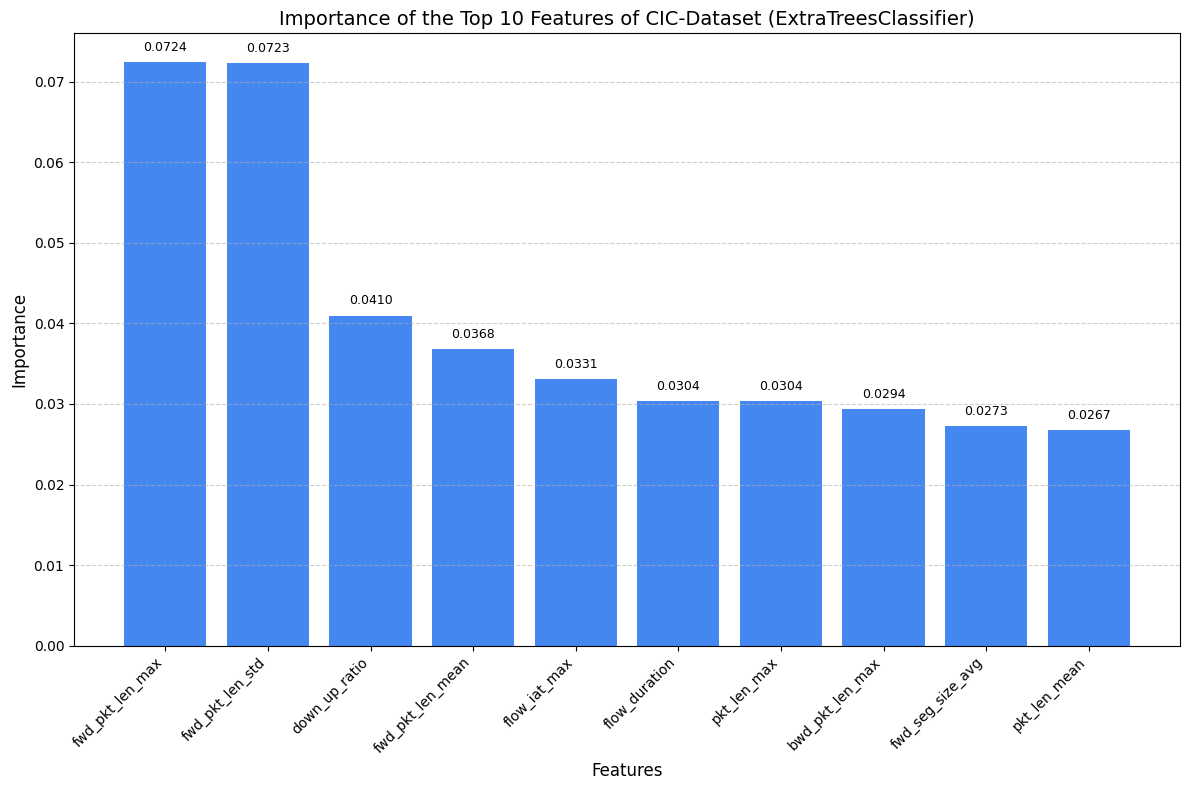


Features and importance scores (Top 10 - CIC):
1. fwd_pkt_len_max: 0.0724
2. fwd_pkt_len_std: 0.0723
3. down_up_ratio: 0.0410
4. fwd_pkt_len_mean: 0.0368
5. flow_iat_max: 0.0331
6. flow_duration: 0.0304
7. pkt_len_max: 0.0304
8. bwd_pkt_len_max: 0.0294
9. fwd_seg_size_avg: 0.0273
10. pkt_len_mean: 0.0267


In [ ]:
bar_color = '#4587F1'  # Blue for CIC-Dataset features

# Visualize the importance of the top 10 features in the CIC-Dataset
cic_top_10_features = cic_feature_importance_df.head(10)
plt.figure(figsize=(12, 8))
bars = plt.bar(cic_top_10_features['Feature'], cic_top_10_features['Importance'], color=bar_color)

# Add the values ​​above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.001, f'{yval:.4f}', ha='center', va='bottom', fontsize=9)

# Visual settings
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Importance", fontsize=12)
plt.title("Importance of the Top 10 Features of CIC-Dataset (ExtraTreesClassifier)", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Print the features and their scores
print("\nFeatures and importance scores (Top 10 - CIC):")
for i, (feature, importance) in enumerate(zip(cic_top_10_features['Feature'], cic_top_10_features['Importance'])):
    print(f"{i+1}. {feature}: {importance:.4f}")

In [ ]:
# Selection of the 30 best features for training
cic_selected_features = cic_feature_importance_df.head(30)['Feature'].tolist()

In [ ]:
# Get indices of selected features from the original aligned columns
cic_selected_indices = [common_cols_cic.index(feature) for feature in cic_selected_features]

# Create new training and test sets with the selected features
cic_X_train_selected = cic_X_train[:, cic_selected_indices]
cic_X_test_selected = cic_X_test[:, cic_selected_indices]

#*3.2* *Feature Selection in NTL Dataset*

In [ ]:
# Separate features and labels
ntl_X_train = ntl_train_dataset.drop('label', axis=1, errors='ignore')
ntl_y_train = ntl_train_dataset['label']
ntl_X_test = ntl_test_dataset.drop('label', axis=1, errors='ignore')
ntl_y_test = ntl_test_dataset['label']

In [ ]:
# Feature analysis with ExtraTreesClassifier
ntl_et_classifier = ExtraTreesClassifier(
    n_estimators=50,      # Reduce the number of trees for lower consumption
    random_state=42,
    n_jobs=-1             # Use all available cores
)

ntl_et_classifier.fit(ntl_X_train, ntl_y_train)

ExtraTreesClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [ ]:
# Extract importance from features
ntl_feature_importances = ntl_et_classifier.feature_importances_
ntl_feature_names = ntl_X_train.columns

In [ ]:
# Create Feature Importance DataFrame
ntl_feature_importance_df = pd.DataFrame({'Feature': ntl_feature_names, 'Importance': ntl_feature_importances})
ntl_feature_importance_df = ntl_feature_importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
# View all features with their importance scores
ntl_feature_list = ntl_feature_importance_df[['Feature', 'Importance']].values.tolist()
print('Características y puntajes de importancia (NTL-Dataset):')
for feature, importance in ntl_feature_list:
    print(f'{feature}: {importance:.4f}')

Características y puntajes de importancia (NTL-Dataset):
rst_flag_counts: 0.0733
fwd_rst_flag_counts: 0.0427
fwd_fin_flag_counts: 0.0279
fwd_segment_size_cov: 0.0239
std_packets_delta_time: 0.0209
fin_flag_counts: 0.0205
fwd_fin_flag_percentage_in_total: 0.0163
fwd_payload_bytes_cov: 0.0148
payload_bytes_cov: 0.0140
delta_start: 0.0138
bwd_payload_bytes_skewness: 0.0131
cov_payload_bytes_delta_len: 0.0123
fwd_segment_size_max: 0.0121
fwd_rst_flag_percentage_in_fwd_packets: 0.0115
bwd_payload_bytes_cov: 0.0114
min_fwd_payload_bytes_delta_len: 0.0108
mean_header_bytes: 0.0107
packets_IAT_skewness: 0.0105
fwd_fin_flag_percentage_in_fwd_packets: 0.0105
max_header_bytes: 0.0099
handshake_duration: 0.0096
fwd_syn_flag_percentage_in_fwd_packets: 0.0093
handshake_state: 0.0090
cov_header_bytes: 0.0088
mean_fwd_packets_delta_time: 0.0088
packets_IAT_mean: 0.0087
cov_fwd_payload_bytes_delta_len: 0.0087
payload_bytes_mean: 0.0087
packets_IAT_median: 0.0083
fwd_packets_IAT_skewness: 0.0083
psh_fla

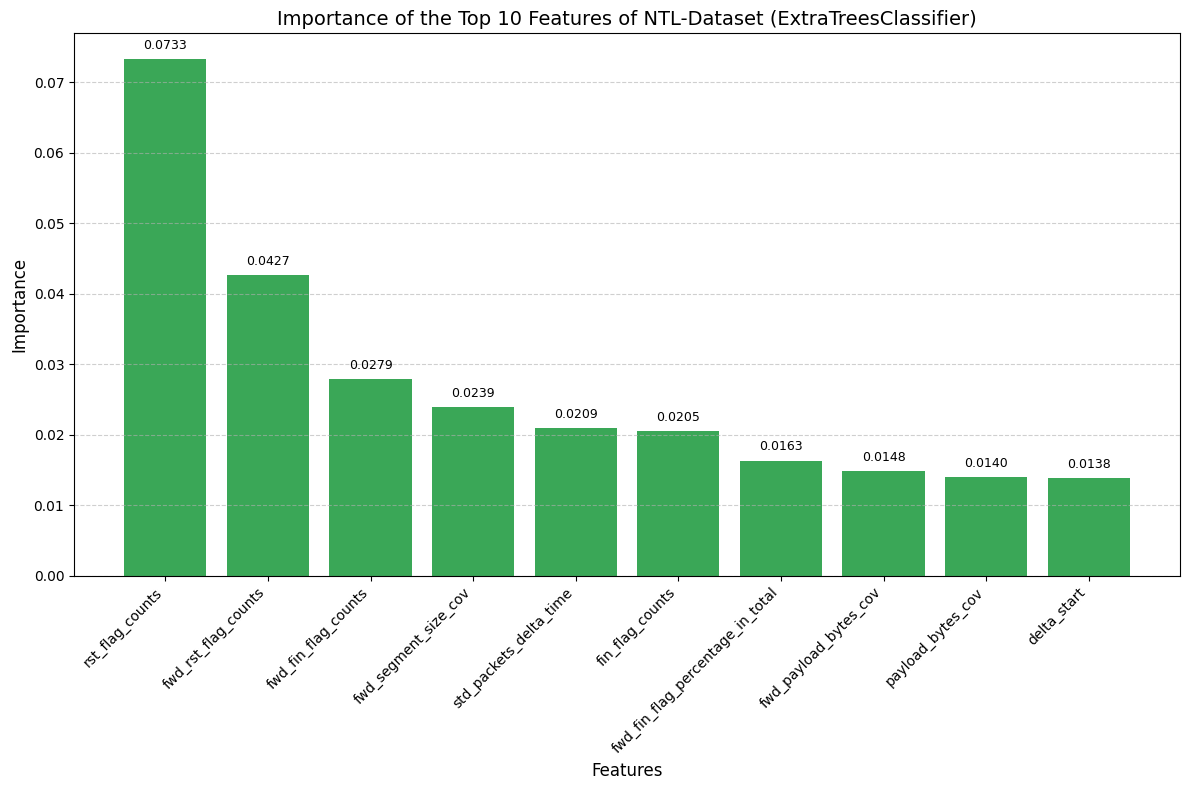


Features and importance scores (Top 10 - NTL):
1. rst_flag_counts: 0.0733
2. fwd_rst_flag_counts: 0.0427
3. fwd_fin_flag_counts: 0.0279
4. fwd_segment_size_cov: 0.0239
5. std_packets_delta_time: 0.0209
6. fin_flag_counts: 0.0205
7. fwd_fin_flag_percentage_in_total: 0.0163
8. fwd_payload_bytes_cov: 0.0148
9. payload_bytes_cov: 0.0140
10. delta_start: 0.0138


In [ ]:
bar_color = '#3AA757'  # Green for NTL-Dataset

# Visualize the importance of the 10 most important features
ntl_top_10_features = ntl_feature_importance_df.head(10)
plt.figure(figsize=(12, 8))
bars = plt.bar(ntl_top_10_features['Feature'], ntl_top_10_features['Importance'], color=bar_color)

# Add the values ​​above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.001, f'{yval:.4f}', ha='center', va='bottom', fontsize=9)

# Visual settings
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Importance", fontsize=12)
plt.title("Importance of the Top 10 Features of NTL-Dataset (ExtraTreesClassifier)", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Print the features and their scores
print("\nFeatures and importance scores (Top 10 - NTL):")
for i, (feature, importance) in enumerate(zip(ntl_top_10_features['Feature'], ntl_top_10_features['Importance'])):
    print(f"{i+1}. {feature}: {importance:.4f}")

In [ ]:
# Select the 30 most important features in both sets
ntl_selected_features = ntl_feature_importance_df.head(30)['Feature'].tolist()
ntl_X_train = ntl_X_train[ntl_selected_features]
ntl_X_test = ntl_X_test[ntl_selected_features]

/tmp/ipython-input-2710097589.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cic_top_features['Dataset'] = 'CIC-Dataset'
/tmp/ipython-input-2710097589.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ntl_top_features['Dataset'] = 'NTL-Dataset'


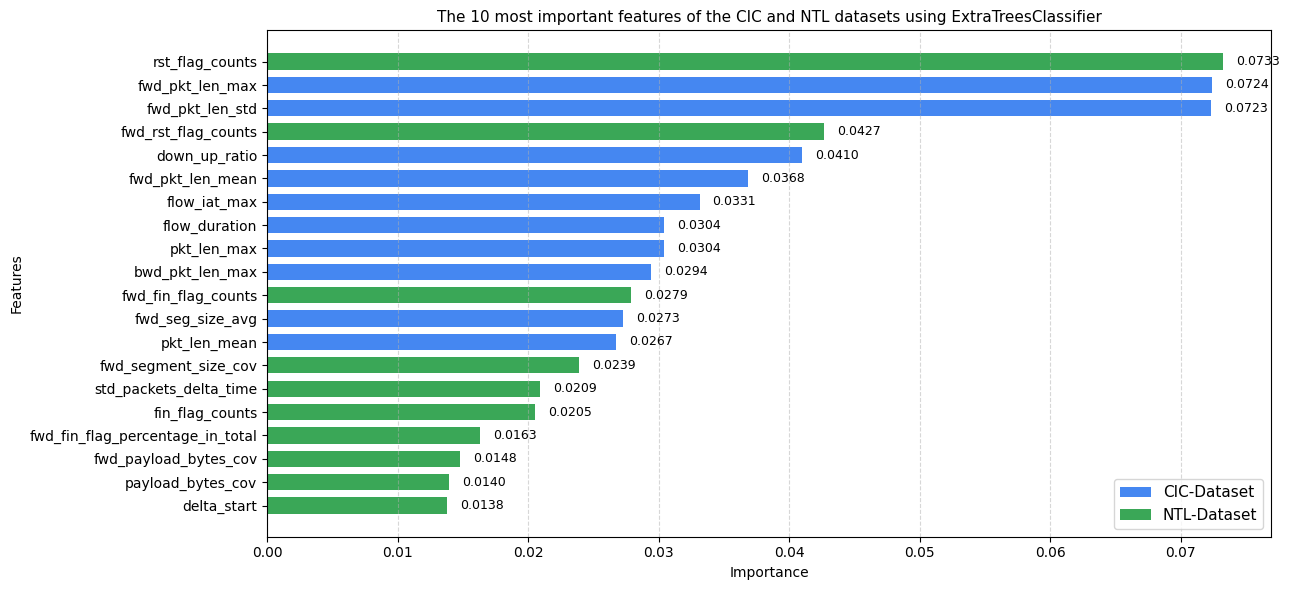

In [ ]:
# Obtain the 10 most important features of both datasets
cic_top_features = cic_feature_importance_df.head(10)
ntl_top_features = ntl_feature_importance_df.head(10)

# Add source column to differentiate them
cic_top_features['Dataset'] = 'CIC-Dataset'
ntl_top_features['Dataset'] = 'NTL-Dataset'

# Combining datasets
combined_features = pd.concat([cic_top_features, ntl_top_features])

# Sort by descending importance
combined_features = combined_features.sort_values(by='Importance', ascending=True)

# Color mapping
color_map = {'CIC-Dataset': '#4587F1', 'NTL-Dataset': '#3AA757'}
colors = combined_features['Dataset'].map(color_map)

# Create a compact figure
plt.figure(figsize=(13, 6))  # Narrow and tall

# Create horizontal bar chart
bars = plt.barh(combined_features['Feature'], combined_features['Importance'], color=colors, height=0.7)

# Add values ​​to the end of each bar
for bar in bars:
    xval = bar.get_width()
    plt.text(xval + 0.001, bar.get_y() + bar.get_height() / 2, f'{xval:.4f}', va='center', fontsize=9)

# Aesthetics of the graph
plt.xlabel("Importance", fontsize=10)
plt.ylabel("Features", fontsize=10)
plt.title("The 10 most important features of the CIC and NTL datasets using ExtraTreesClassifier", fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#4587F1', label='CIC-Dataset'),
    Patch(facecolor='#3AA757', label='NTL-Dataset')
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=11)

plt.tight_layout()
plt.show()

#***4. Training***

#*4.1* *Training using CIC Dataset*

In [ ]:
# Confirm dimensions after feature selection
print("Train dataset size (CIC):", cic_X_train_selected.shape)
print("Test dataset size (CIC):", cic_X_test_selected.shape)

Train dataset size (CIC): (424922, 30)
Test dataset size (CIC): (126715, 30)


In [ ]:
# --- Class Weighting ---
cic_class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(cic_y_train), y=cic_y_train)
cic_class_weight_dict = dict(zip(np.unique(cic_y_train), cic_class_weights))
print(f"Pesos de clase para el dataset CIC: {cic_class_weight_dict}")

Pesos de clase para el dataset CIC: {np.int64(0): np.float64(1.2394178042235444), np.int64(1): np.float64(0.8381038413898115)}


In [ ]:
# Cross-validation con KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Cross-validation y entrenamiento para XGBoost
print("Validación cruzada y entrenamiento de XGBoost para CIC...")
cic_xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0.1,
    reg_lambda=1,
    tree_method="hist",
    booster="gbtree",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=cic_class_weight_dict.get(1, 1) # Ponderación de clases para XGBoost
)
cic_scores_xgb = cross_val_score(cic_xgb_model, cic_X_train_selected, cic_y_train, cv=kf, scoring='accuracy')
print(f"Precisión de validación cruzada de XGBoost (CIC): {cic_scores_xgb.mean():.4f} (+/- {cic_scores_xgb.std():.4f})")
cic_xgb_model.fit(cic_X_train_selected, cic_y_train)

Validación cruzada y entrenamiento de XGBoost para CIC...
Precisión de validación cruzada de XGBoost (CIC): 0.9994 (+/- 0.0001)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
# Cross-validation y entrenamiento para Random Forest
print("Validación cruzada y entrenamiento de Random Forest para CIC...")
cic_rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    class_weight=cic_class_weight_dict # Ponderación de clases para Random Forest
)
cic_scores_rf = cross_val_score(cic_rf_model, cic_X_train_selected, cic_y_train, cv=kf, scoring='accuracy')
print(f"Precisión de validación cruzada de Random Forest (CIC): {cic_scores_rf.mean():.4f} (+/- {cic_scores_rf.std():.4f})")
cic_rf_model.fit(cic_X_train_selected, cic_y_train)

Validación cruzada y entrenamiento de Random Forest para CIC...
Precisión de validación cruzada de Random Forest (CIC): 0.9991 (+/- 0.0001)


RandomForestClassifier(class_weight={np.int64(0): np.float64(1.2394178042235444),
                                     np.int64(1): np.float64(0.8381038413898115)},
                       max_depth=6, n_jobs=-1, random_state=42)

#*4.2* *Training using NTL Dataset*

In [ ]:
# Normalization after feature selection
scaler_ntl = StandardScaler()
ntl_X_train_scaled = scaler_ntl.fit_transform(ntl_X_train)
ntl_X_test_scaled = scaler_ntl.transform(ntl_X_test)

In [ ]:
# --- Class Weighting ---
ntl_class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(ntl_y_train), y=ntl_y_train)
ntl_class_weight_dict = dict(zip(np.unique(ntl_y_train), ntl_class_weights))
print(f"Pesos de clase para el dataset NTL: {ntl_class_weight_dict}")

Pesos de clase para el dataset NTL: {np.int64(0): np.float64(1.0080843628827567), np.int64(1): np.float64(0.992044271115836)}


In [ ]:
# Cross-validation y entrenamiento para XGBoost
print("Validación cruzada y entrenamiento de XGBoost para NTL...")
ntl_xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0.1,
    reg_lambda=1,
    tree_method="hist",
    booster="gbtree",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=ntl_class_weight_dict.get(1, 1)
)
ntl_scores_xgb = cross_val_score(ntl_xgb_model, ntl_X_train_scaled, ntl_y_train, cv=kf, scoring='accuracy')
print(f"Precisión de validación cruzada de XGBoost (NTL): {ntl_scores_xgb.mean():.4f} (+/- {ntl_scores_xgb.std():.4f})")
ntl_xgb_model.fit(ntl_X_train_scaled, ntl_y_train)

Validación cruzada y entrenamiento de XGBoost para NTL...
Precisión de validación cruzada de XGBoost (NTL): 1.0000 (+/- 0.0000)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
# Cross-validation y entrenamiento para Random Forest
print("Validación cruzada y entrenamiento de Random Forest para NTL...")
ntl_rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    class_weight=ntl_class_weight_dict
)
ntl_scores_rf = cross_val_score(ntl_rf_model, ntl_X_train_scaled, ntl_y_train, cv=kf, scoring='accuracy')
print(f"Precisión de validación cruzada de Random Forest (NTL): {ntl_scores_rf.mean():.4f} (+/- {ntl_scores_rf.std():.4f})")
ntl_rf_model.fit(ntl_X_train_scaled, ntl_y_train)

Validación cruzada y entrenamiento de Random Forest para NTL...
Precisión de validación cruzada de Random Forest (NTL): 1.0000 (+/- 0.0000)


RandomForestClassifier(class_weight={np.int64(0): np.float64(1.0080843628827567),
                                     np.int64(1): np.float64(0.992044271115836)},
                       max_depth=6, n_jobs=-1, random_state=42)

#***5. Evaluation***

#*5.1* *Evaluation using CIC Dataset*


CIC XGBoost Ranking Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     50839
           1       0.99      1.00      1.00     75876

    accuracy                           0.99    126715
   macro avg       1.00      0.99      0.99    126715
weighted avg       0.99      0.99      0.99    126715



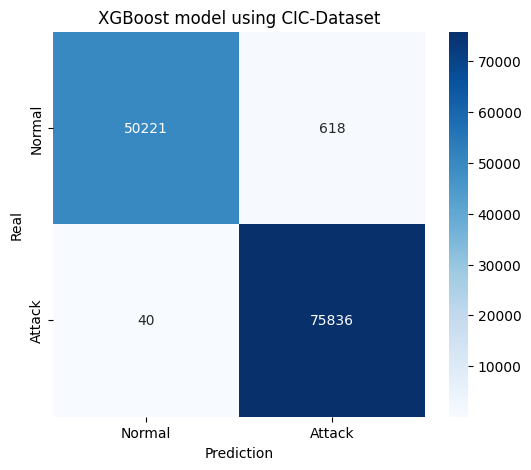

In [ ]:
# Model evaluation (XGBoost)
cic_y_pred_xgb = cic_xgb_model.predict(cic_X_test_selected)
print('\nCIC XGBoost Ranking Report:')
print(classification_report(cic_y_test, cic_y_pred_xgb))

# Confusion matrix (XGBoost)
conf_matrix_xgb = confusion_matrix(cic_y_test, cic_y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('XGBoost model using CIC-Dataset')
plt.show()


CIC Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     50839
           1       0.99      1.00      1.00     75876

    accuracy                           1.00    126715
   macro avg       1.00      1.00      1.00    126715
weighted avg       1.00      1.00      1.00    126715



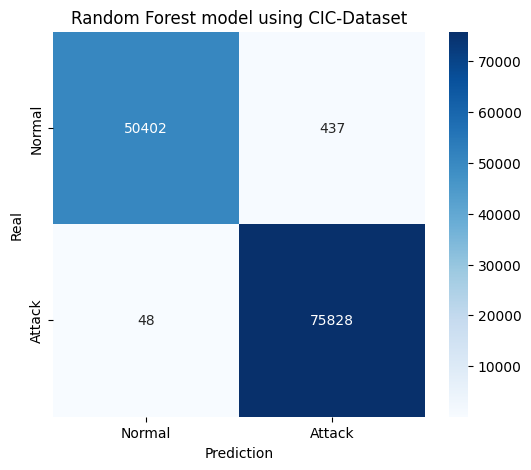

In [ ]:
# Model evaluation (Random Forest)
cic_y_pred_rf = cic_rf_model.predict(cic_X_test_selected)
print('\nCIC Random Forest Classification Report:')
print(classification_report(cic_y_test, cic_y_pred_rf))

# Confusion matrix (Random Forest)
conf_matrix_rf = confusion_matrix(cic_y_test, cic_y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Random Forest model using CIC-Dataset')
plt.show()

#*5.2* *Evaluation using NTL Dataset*


NTL XGBoost Ranking Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    106086
           1       1.00      1.00      1.00     97589

    accuracy                           1.00    203675
   macro avg       1.00      1.00      1.00    203675
weighted avg       1.00      1.00      1.00    203675



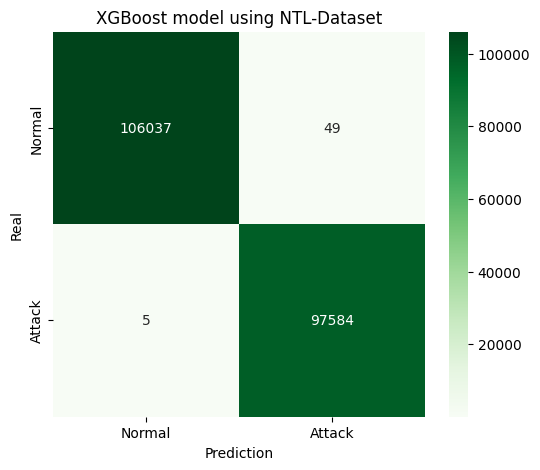

In [ ]:
# Model evaluation (XGBoost)
ntl_y_pred_xgb = ntl_xgb_model.predict(ntl_X_test_scaled)
print('\nNTL XGBoost Ranking Report:')
print(classification_report(ntl_y_test, ntl_y_pred_xgb))

# Confusion matrix (XGBoost)
conf_matrix_xgb = confusion_matrix(ntl_y_test, ntl_y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('XGBoost model using NTL-Dataset')
plt.show()


NTL Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    106086
           1       1.00      1.00      1.00     97589

    accuracy                           1.00    203675
   macro avg       1.00      1.00      1.00    203675
weighted avg       1.00      1.00      1.00    203675



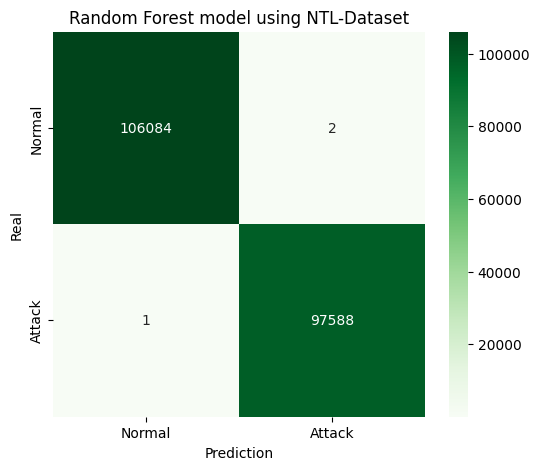

In [ ]:
# Evaluación del modelo (Random Forest)
ntl_y_pred_rf = ntl_rf_model.predict(ntl_X_test_scaled)
print('\nNTL Random Forest Classification Report:')
print(classification_report(ntl_y_test, ntl_y_pred_rf))

# Matriz de confusión (Random Forest)
conf_matrix_rf = confusion_matrix(ntl_y_test, ntl_y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Random Forest model using NTL-Dataset')
plt.show()


Model Evaluation Table (4 decimal places):

                          Model  Accuracy  Precision   Recall  F1-Score      FNR
      XGBoost using CIC-Dataset  0.994807   0.991917 0.999473  0.995680 0.000527
Random Forest using CIC-Dataset  0.996173   0.994270 0.999367  0.996812 0.000633
      XGBoost using NTL-Dataset  0.999735   0.999498 0.999949  0.999723 0.000051
Random Forest using NTL-Dataset  0.999985   0.999980 0.999990  0.999985 0.000010


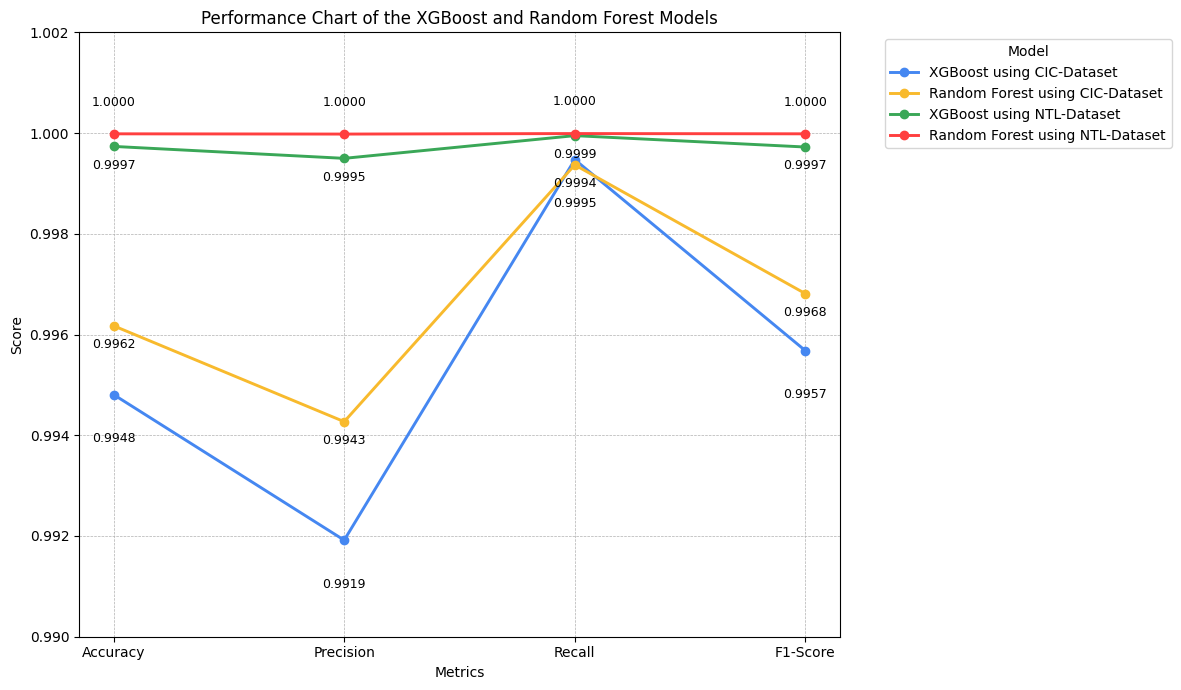

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# Dictionary to store metrics
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'FNR': []
}

# Function to calculate FNR
def fnr_score(y_true, y_pred):
    """
    Calculates the False Negative Rate (FNR).

    FNR = FN / (FN + TP)
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Avoid division by zero
    if (fn + tp) == 0:
        return 0.0
    return fn / (fn + tp)

# Function to calculate and save metrics
def evaluate_model(name, y_true, y_pred):
    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy_score(y_true, y_pred))
    metrics['Precision'].append(precision_score(y_true, y_pred, zero_division=0))
    metrics['Recall'].append(recall_score(y_true, y_pred, zero_division=0))
    metrics['F1-Score'].append(f1_score(y_true, y_pred, zero_division=0))
    metrics['FNR'].append(fnr_score(y_true, y_pred))

# Evaluate the 4 models (assuming y_test and y_pred variables are defined)
evaluate_model('XGBoost using CIC-Dataset', cic_y_test, cic_y_pred_xgb)
evaluate_model('Random Forest using CIC-Dataset', cic_y_test, cic_y_pred_rf)
evaluate_model('XGBoost using NTL-Dataset', ntl_y_test, ntl_y_pred_xgb)
evaluate_model('Random Forest using NTL-Dataset', ntl_y_test, ntl_y_pred_rf)

# Create DataFrame
metrics_df = pd.DataFrame(metrics)

# Round all numerical columns to 4 decimal places
metrics_df = metrics_df.round(6)

# Print a detailed table
print('\nModel Evaluation Table (4 decimal places):\n')
print(metrics_df.to_string(index=False))

# Convert the DataFrame for plotting
# Exclude the 'FNR' column from the melted DataFrame for plotting
metrics_df_melted = metrics_df.drop('FNR', axis=1).melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create a line plot
plt.figure(figsize=(12, 7))

# Ordered list of metrics for the X-axis, excluding FNR
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Custom colors per model
model_colors = {
    'XGBoost using CIC-Dataset': '#4587F1',
    'Random Forest using CIC-Dataset': '#F8BA2D',
    'XGBoost using NTL-Dataset': '#3AA757',
    'Random Forest using NTL-Dataset': '#FF3F3F'
}

# Offsets for numerical labels to prevent overlap
offsets = {
    'XGBoost using CIC-Dataset': -0.001,
    'Random Forest using CIC-Dataset': -0.0005,
    'XGBoost using NTL-Dataset': -0.0005,
    'Random Forest using NTL-Dataset': 0.0005
}

# Draw a line for each model
for model in metrics_df['Model']:
    model_data = metrics_df_melted[metrics_df_melted['Model'] == model]

    # Filter the data to include only the desired metric labels in the correct order
    model_data_ordered = model_data.set_index('Metric').loc[metric_labels].reset_index()

    x = model_data_ordered['Metric']
    y = model_data_ordered['Score']
    plt.plot(x, y, marker='o', label=model, color=model_colors[model], linewidth=2.1)

    # Add numerical labels with 4 decimal places
    for i, score in enumerate(y):
        plt.text(i, score + offsets[model], f'{score:.4f}', ha='center', va='bottom', fontsize=9)

# Configure the plot
plt.title('Performance Chart of the XGBoost and Random Forest Models')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0.99, 1.002)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()